In [1]:
import nltk
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image 
from IPython.core.display import Image, display
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import pymongo
import datetime
import bson
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import random
from itertools import permutations
from nltk.tokenize import sent_tokenize, word_tokenize
username = "tagger-admin"
password = "tvaiadmin"
db_client = pymongo.MongoClient('104.198.62.226', username=username,
                                password=password,
                                authSource='tags',
                                authMechanism='SCRAM-SHA-256', port=27017).tags


import aerospike
config = {
    'hosts': [('35.228.136.58', 3000)]
}
client = aerospike.client(config).connect()
data_as_key = ("ids_to_validate", "data", "data")

# Search & Feed

In [3]:
import csv

In [7]:
fields = {datetime.datetime.now():{ "search": db_client["tweets_pipeline_v2"].find({"status": "graphicone_search"}).count(),
                                    "feed": db_client["tweets_pipeline_v2"].find({"status": "graphicone_feed"}).count(),
                                   "total":db_client["tweets_pipeline_v2"].find({"status": "graphicone_search"}).count() + db_client["tweets_pipeline_v2"].find({"status": "graphicone_feed"}).count(),
                                   "pipelined": db_client["tweets_pipeline_v2"].find({"status": "pipelined"}).count(),
                                   "validated": db_client["tweets_pipeline_v2"].find({"status": "validated"}).count(),
                                   "reserved": db_client["tweets_pipeline_v2"].find({"status": "reserved"}).count(),
                                   "deleted": db_client["tweets_pipeline_v2"].find({"status": "deleted"}).count(),
                                   "deleted_from_analytics": db_client["tweets_pipeline_v2"].find({"status": "deleted_from_analytics"}).count(),
                                   "tags:": len(client.get(data_as_key)[-1]['tags'])
                                  }
         }
with open(r'logs/statistics', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([fields])
print(fields)

{datetime.datetime(2020, 3, 4, 15, 13, 28, 752972): {'search': 4995, 'feed': 710, 'total': 5705, 'pipelined': 5903, 'validated': 1431, 'reserved': 17390, 'deleted': 51766, 'deleted_from_analytics': 2128, 'tags:': 5508}}


In [4]:
def UserStats():
    pipeline = [{"$group": {"_id": {
                                    "date":{"$dateToString": { "format": "%Y-%m-%d", "date": "$validated_timestamp" }},
                                    "status": "$status", 
                                    "validator":"$validator_username",                                
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    counter = 0
    FullDict = {}
    for i in aggregateResults:
        counter+=1
        if "validator" in i["_id"]:
            if i["_id"]["status"] in ["validated", "deleted", "graphicone_search", "graphicone_feed", "deleted_from_analytics"]:
                newDict = {}
                newDict["date"] = i["_id"]["date"]
                newDict[i["_id"]["status"]] = i["count"]
                newDict["user"] = i["_id"]["validator"]
                FullDict[counter] = newDict
    df = pd.DataFrame.from_dict(FullDict, orient='index').groupby(["date", "user"]).sum().sort_values(by="date", ascending=False)
    df["TOTAL SUM"] = df[[col for col in df.columns]].sum(axis = 1, skipna = True)
    df["APP"] = df["graphicone_search"]+df["graphicone_feed"]
    df["TOTAL DELETED, %"] = (((df["deleted"]+df["deleted_from_analytics"])/(df["TOTAL SUM"]))*100).round(2)
    df["VALIDATOR ERROR, %"] = ((df["deleted_from_analytics"]/(df["APP"]+df["deleted_from_analytics"]))*100).round(2)
    df.to_excel("logs/"+"userStats"+str(datetime.datetime.now().date())+".xlsx")
    return df

In [5]:
df = UserStats()
df.head(30)

validated  graphicone_search  deleted  graphicone_feed  \
date       user                                                               
2020-03-22 tagger48       19.0                1.0      3.0              0.0   
           bond            0.0                0.0      1.0              0.0   
2020-03-21 tagger48       16.0                1.0      8.0              3.0   
           evv             2.0                0.0      0.0              0.0   
2020-03-20 tagger48       14.0               16.0     16.0              1.0   
2020-03-19 tagger48       12.0               21.0     17.0              1.0   
2020-03-18 tagger48        7.0               36.0     17.0              0.0   
2020-03-17 tagger48        0.0               50.0     11.0              0.0   
2020-03-15 tagger48        0.0               54.0     19.0              0.0   
2020-03-14 tagger48       17.0               21.0     10.0              0.0   
2020-03-13 tagger48        1.0                4.0     13.0              5.0   
2020-03-12 tagger48        2.0               14.0     25.0             11.0   
2020-03-11 tagger48        0.0                6.0     10.0              5.0   
2020-03-09 tagger48        0.0                4.0      3.0              0.0   
2020-03-08 tagger48       25.0               34.0     21.0              0.0   
2020-03-07 tagger48       20.0                9.0     70.0             27.0   
2020-03-06 tagger48       15.0               14.0     66.0             16.0   
2020-03-05 tagger48        5.0                9.0     54.0             15.0   
2020-03-04 bond            0.0                0.0      1.0              0.0   
           tagger48        0.0               10.0     76.0              2.0   
2020-03-03 bond            0.0                0.0      1.0              0.0   
           tagger48        0.0               14.0     15.0              0.0   
2020-03-02 tagger48        0.0               50.0     15.0              0.0   
2020-02-29 tagger48        0.0               67.0     18.0              0.0   
2020-02-28 tagger48        0.0               59.0     14.0              0.0   
2020-02-27 tagger48        0.0               28.0     10.0              0.0   
2020-02-26 tagger48        0.0               61.0     11.0              0.0   
2020-02-25 tagger48        0.0               64.0     40.0              0.0   
2020-02-24 tagger48        0.0               14.0      1.0              0.0   
2020-02-23 tagger48        7.0               35.0     11.0              0.0   

                     deleted_from_analytics  \
date       user                               
2020-03-22 tagger48                     0.0   
           bond                         0.0   
2020-03-21 tagger48                     0.0   
           evv                          0.0   
2020-03-20 tagger48                     0.0   
2020-03-19 tagger48                     4.0   
2020-03-18 tagger48                     0.0   
2020-03-17 tagger48                     0.0   
2020-03-15 tagger48                     0.0   
2020-03-14 tagger48                     0.0   
2020-03-13 tagger48                     0.0   
2020-03-12 tagger48                     3.0   
2020-03-11 tagger48                     0.0   
2020-03-09 tagger48                     0.0   
2020-03-08 tagger48                     1.0   
2020-03-07 tagger48                     1.0   
2020-03-06 tagger48                     0.0   
2020-03-05 tagger48                     3.0   
2020-03-04 bond                         0.0   
           tagger48                     1.0   
2020-03-03 bond                         0.0   
           tagger48                     0.0   
2020-03-02 tagger48                     0.0   
2020-02-29 tagger48                     0.0   
2020-02-28 tagger48                     0.0   
2020-02-27 tagger48                     0.0   
2020-02-26 tagger48                     0.0   
2020-02-25 tagger48                     0.0   
2020-02-24 tagger48                     0.0   
2020-02-23 tagger48                

In [9]:
def stats():
    pipeline = [{"$group": {"_id": {
                                    "date":{"$dateToString": { "format": "%Y-%m-%d", "date": "$validated_timestamp" }},
                                    "status": "$status",
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    counter = 0
    FullDict = {}
    for i in aggregateResults:
        if "status" in i["_id"]:
            counter+=1
            newDict = {}
            newDict["date"] = i["_id"]["date"]
            newDict[i["_id"]["status"]] = i["count"]
            FullDict[counter] = newDict
            
    df = pd.DataFrame.from_dict(FullDict, orient='index').groupby(["date"]).sum().sort_values(by="date", ascending=True)
    df["TOTAL SUM"] = df[[col for col in df.columns]].sum(axis = 1, skipna = True)
    df["APP"] = df["graphicone_search"]+df["graphicone_feed"]
    df["TOTAL DELETED, %"] = (((df["deleted"]+df["deleted_from_analytics"])/(df["TOTAL SUM"]))*100).round(2)
    df["VALIDATOR ERROR, %"] = ((df["deleted_from_analytics"]/(df["APP"]+df["deleted_from_analytics"]))*100).round(2)
    
    colors = ["#EEA04D","#E4D9B5","#a0c8c9","#3F647C","#3F3D50"]
    ax1 = df[['deleted', 'deleted_from_analytics','validated','graphicone_search', 'graphicone_feed']][df.index>="2019-12-02"].plot.bar(stacked=True, colors=colors, figsize=(15,7))

    df2 = df[['deleted', 'deleted_from_analytics','validated','graphicone_search', 'graphicone_feed']]
    df2 = df2.div(df2.sum(axis=1), axis=0)*100
    
    ax = df2[df2.index>="2019-12-02"].plot.bar(stacked=True, colors=colors, figsize=(15,7))    
    df.to_excel("logs/"+"statsDaily"+str(datetime.datetime.now().date())+".xlsx")
    
    
    df = df.sort_values(by="date", ascending=False)[["graphicone_search", "graphicone_feed"]]
    df = df.reset_index()
    df.date = pd.to_datetime(df.date)
    df_feed = df.groupby('date')["graphicone_feed"].sum().cumsum().reset_index()
    df_feed.set_index('date', inplace=True)
    df_search = df.groupby('date')["graphicone_search"].sum().cumsum().reset_index()
    df_search.set_index('date', inplace=True)
    df_common = df_search.join(df_feed)
    df_common.index = df_common.index.strftime('%Y-%m-%d')
    colors = ["#3F647C","#3F3D50"]
    df_common.plot(kind="bar", figsize=(15,7), colors = colors)    
    #2019-12-10 - launch algos
    return df

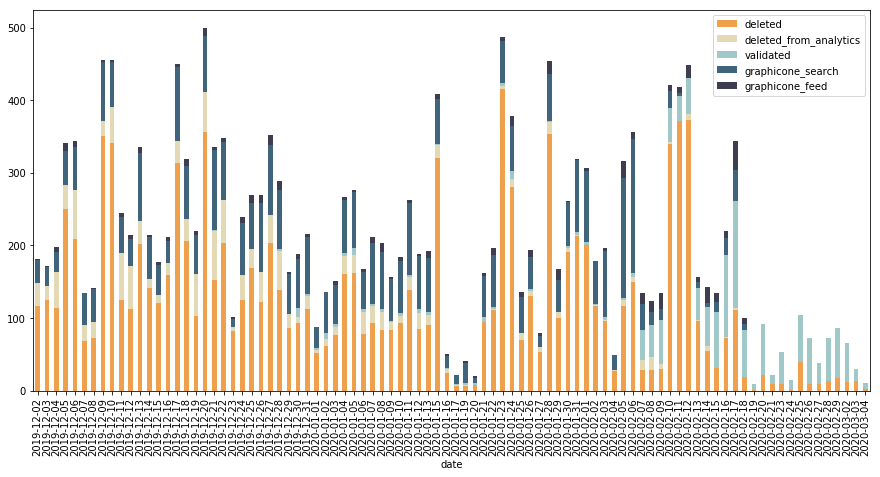

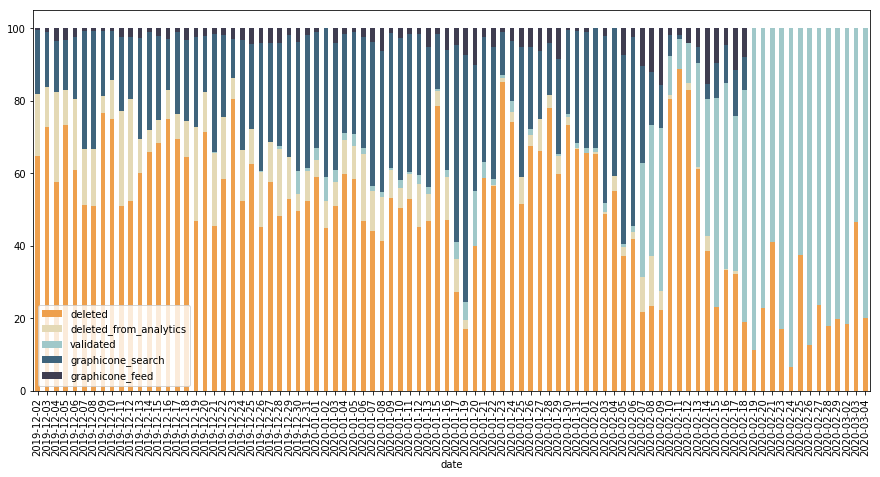

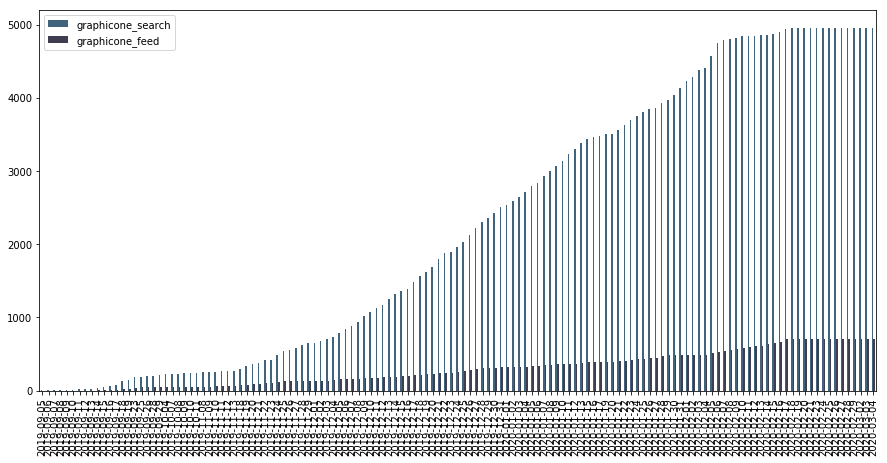

In [10]:
df = stats()

# Image Types

In [8]:
def GraphicTypes():
    pipeline = [{"$group": {"_id": {
                                    "status": "pipelined",
                                    "gType": "$graph_type"
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    FullDict = {}
    counter = 0
    for i in aggregateResults:
        if "gType" in i["_id"]:
            counter+=1
            newDict = {}
            newDict["Graphic type"] = i["_id"]["gType"]
            newDict["count"] = i["count"]
            FullDict[counter] = newDict
        df = pd.DataFrame.from_dict(FullDict, orient='index')    
        
    df["count"].groupby(df["Graphic type"]).sum().plot(kind='pie', figsize=(15,7), autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(df["count"])/100))        
    
    return df

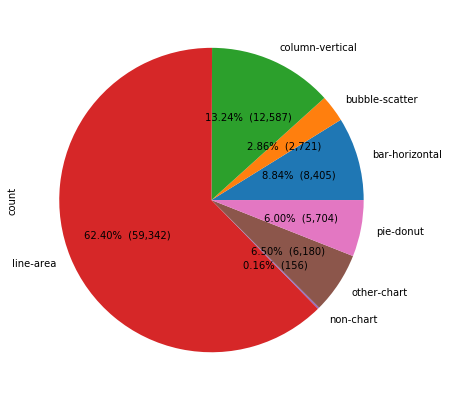

In [9]:
GraphicTypeDF = GraphicTypes()

In [11]:
def imageTypes():
    pipeline = [{"$group": {"_id": {
                                    "gType": "$img_type",
                                    "status": "pipelined",
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    
    FullDict = {}
    counter = 0
    for i in aggregateResults:
        if "gType" in i["_id"]:
            counter+=1
            newDict = {}
            newDict["Image type"] = i["_id"]["gType"]
            newDict["count"] = i["count"]
            FullDict[counter] = newDict
    df = pd.DataFrame.from_dict(FullDict, orient='index')    

    df["count"].groupby(df["Image type"]).sum().plot(kind='pie', figsize=(15,7), autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(df["count"])/100))
#     plt.axis('equal')
#     plt.show()
#     return df  

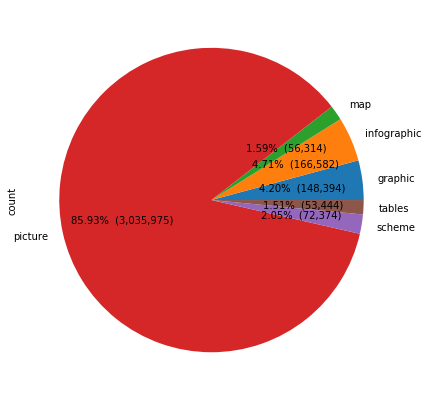

In [12]:
ImageTypeDF = imageTypes()

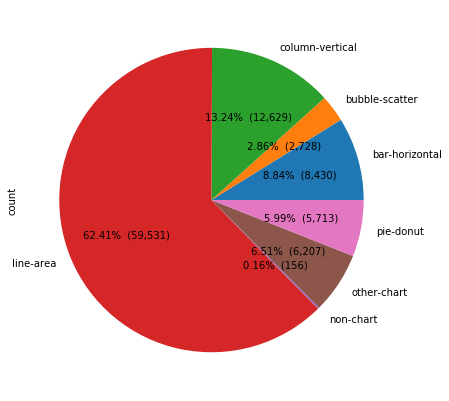

In [47]:
def GraphicTypes():
    pipeline = [{"$group": {"_id": {
                                    "status": "graphicone_feed",
                                    "gType": "$graph_type"
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    FullDict = {}
    counter = 0
    for i in aggregateResults:
        if "gType" in i["_id"]:
            counter+=1
            newDict = {}
            newDict["Graphic type"] = i["_id"]["gType"]
            newDict["count"] = i["count"]
            FullDict[counter] = newDict
        df = pd.DataFrame.from_dict(FullDict, orient='index')    
        
    df["count"].groupby(df["Graphic type"]).sum().plot(kind='pie', figsize=(15,7), autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(df["count"])/100))        
    
    return df
a=GraphicTypes()

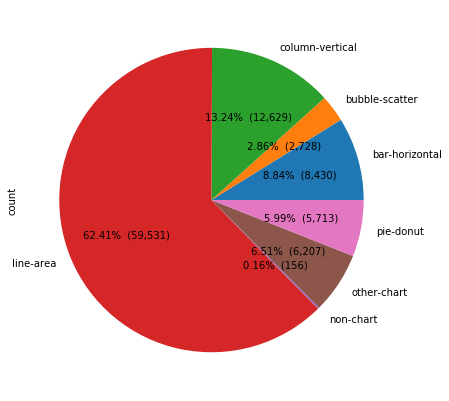

In [48]:
def GraphicTypes():
    pipeline = [{"$group": {"_id": {
                                    "status": "graphicone_search",
                                    "gType": "$graph_type"
                                    }, 
                            "count": {"$sum": 1},
                           }             
                },


               {"$sort": {"_id": -1}}]
    aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
    FullDict = {}
    counter = 0
    for i in aggregateResults:
        if "gType" in i["_id"]:
            counter+=1
            newDict = {}
            newDict["Graphic type"] = i["_id"]["gType"]
            newDict["count"] = i["count"]
            FullDict[counter] = newDict
        df = pd.DataFrame.from_dict(FullDict, orient='index')    
        
    df["count"].groupby(df["Graphic type"]).sum().plot(kind='pie', figsize=(15,7), autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(df["count"])/100))        
    
    return df
a=GraphicTypes()

In [54]:
# for i in db_client["tweets_pipeline_v2"].find({
# #                                                 'validator_username': "tagger5",
#                                               "status": "deleted",
#                                                "validated_timestamp": {"$gte" : datetime.datetime(2019,12,14),
#                                                                       "$lte" : datetime.datetime(2019,12,16)}
#                                               }):
# #     print(i)
#     if "s3_url" in i:
#         print(i["validator_username"])
# #         print(i)
#         print("TYPE:",i['graph_type'])
#         display(Image(i['s3_url'], unconfined=True))
# #         break

In [12]:
import numpy as np

In [13]:
TagsCounter = []
NumberOfGraphs = 0
for i in db_client["tweets_pipeline_v2"].find({"status": "graphicone_search"}):
    TagsCounter += i["grafeed_confirmed"]
    NumberOfGraphs += 1
for i in db_client["tweets_pipeline_v2"].find({"status": "graphicone_feed"}):
    TagsCounter += i["grafeed_confirmed"]
    NumberOfGraphs += 1
# for i in db_client["tweets_pipeline_v2"].find({"status": "validated"}):
#     TagsCounter += i["confirmed_after_validate"]
#     NumberOfGraphs += 1    
# NumberOfGraphs    

In [14]:
TagsStatsInApp = pd.DataFrame.from_dict(dict(Counter(TagsCounter).most_common()), orient = 'index')
TagsStatsInApp.columns = ["counter"]
TagsStatsInApp["NumberOfGraphics"] = np.nan
TagsStatsInApp.loc["us","NumberOfGraphics"] = NumberOfGraphs
TagsStatsInApp.to_excel("TagsStatsInApp.xlsx")
TagsStatsInApp

,counter,NumberOfGraphics
us,1365,3540.0
index,472,NaN
china,469,NaN
global,460,NaN
uk,391,NaN
commodities,363,NaN
eu,361,NaN
social,329,NaN
germany,317,NaN
trade,304,NaN


In [9]:
pipeline = [{"$group": {"_id": {
                                "date":{"$dateToString": { "format": "%Y-%m-%d", "date": "$validated_timestamp" }},
                                "status": "$status", 
                                "validator":"$validator_username",                                
                                }, 
                        "count": {"$sum": 1},
                       }             
            },


           {"$sort": {"_id": -1}}]
aggregateResults = list(db_client.tweets_pipeline_v2.aggregate(pipeline))
counter = 0
FullDict = {}
for i in aggregateResults:
    counter+=1
    if "validator" in i["_id"]:
        if i["_id"]["status"] in ["validated", "deleted", "graphicone_search", "graphicone_feed", "deleted_from_analytics"]:
            newDict = {}
            newDict["date"] = i["_id"]["date"]
            newDict[i["_id"]["status"]] = i["count"]
            newDict["user"] = i["_id"]["validator"]
            FullDict[counter] = newDict
        
FullDict        
df = pd.DataFrame.from_dict(FullDict, orient='index').groupby(["date", "user"]).sum().sort_values(by="date", ascending=False)
df["TOTAL SUM"] = df[[col for col in df.columns]].sum(axis = 1, skipna = True)
df["APP"] = df["graphicone_search"]+df["graphicone_feed"]
df["TOTAL DELETED, %"] = (((df["deleted"]+df["deleted_from_analytics"])/(df["TOTAL SUM"]))*100).round(2)
df["VALIDATOR ERROR, %"] = ((df["deleted_from_analytics"]/(df["APP"]+df["deleted_from_analytics"]))*100).round(2)
df.to_excel("logs/"+"userStats"+str(datetime.datetime.now().date())+".xlsx")

In [10]:
df

validated  graphicone_search  deleted  graphicone_feed  \
date       user                                                               
2020-03-22 tagger48       19.0                1.0      3.0              0.0   
           bond            0.0                0.0      1.0              0.0   
2020-03-21 tagger48       16.0                1.0      8.0              3.0   
           evv             2.0                0.0      0.0              0.0   
2020-03-20 tagger48       14.0               16.0     16.0              1.0   
2020-03-19 tagger48       12.0               21.0     17.0              1.0   
2020-03-18 tagger48        7.0               36.0     17.0              0.0   
2020-03-17 tagger48        0.0               50.0     11.0              0.0   
2020-03-15 tagger48        0.0               54.0     19.0              0.0   
2020-03-14 tagger48       17.0               21.0     10.0              0.0   
2020-03-13 tagger48        1.0                4.0     13.0              5.0   
2020-03-12 tagger48        2.0               14.0     25.0             11.0   
2020-03-11 tagger48        0.0                6.0     10.0              5.0   
2020-03-09 tagger48        0.0                4.0      3.0              0.0   
2020-03-08 tagger48       25.0               34.0     21.0              0.0   
2020-03-07 tagger48       20.0                9.0     70.0             27.0   
2020-03-06 tagger48       15.0               14.0     66.0             16.0   
2020-03-05 tagger48        5.0                9.0     54.0             15.0   
2020-03-04 bond            0.0                0.0      1.0              0.0   
           tagger48        0.0               10.0     76.0              2.0   
2020-03-03 bond            0.0                0.0      1.0              0.0   
           tagger48        0.0               14.0     15.0              0.0   
2020-03-02 tagger48        0.0               50.0     15.0              0.0   
2020-02-29 tagger48        0.0               67.0     18.0              0.0   
2020-02-28 tagger48        0.0               59.0     14.0              0.0   
2020-02-27 tagger48        0.0               28.0     10.0              0.0   
2020-02-26 tagger48        0.0               61.0     11.0              0.0   
2020-02-25 tagger48        0.0               64.0     40.0              0.0   
2020-02-24 tagger48        0.0               14.0      1.0              0.0   
2020-02-23 tagger48        7.0               35.0     11.0              0.0   
...                        ...                ...      ...              ...   
2019-09-16 share7          0.0                0.0      0.0              1.0   
           share4          0.0                2.0      0.0              1.0   
           bond            0.0                3.0      0.0              2.0   
           andrew01        0.0                1.0      0.0              0.0   
2019-09-15 tagger1         0.0                1.0      0.0              0.0   
           adam            0.0                1.0      0.0              0.0   
           bond            0.0                1.0      0.0              0.0   
           share4          0.0                3.0      0.0              0.0   
           tagger3         0.0                1.0      0.0              0.0   
           yurin           0.0                2.0      0.0              0.0   
           tagger5         0.0                3.0      0.0              0.0   
2019-09-14 tagger3         0.0                1.0      0.0              0.0   
           bond            0.0                1.0      0.0              0.0   
           tagger1         0.0                8.0      0.0              0.0   
           share7          0.0                0.0      0.0              1.0   
           tagger4         0.0                1.0      0.0              0.0   
           tagger5         0.0                1.0      0.0              1.0   
           yurin           0.0                1.0      0.0             

In [ ]:
"xyn", "pizda"

In [11]:
a = []

In [12]:
if not a:
    print("TRASH")
else:
    print("ZAEBIS")

TRASH


In [66]:
db_client["tweets_pipeline_v2"].find({"status": "trasher"}).count()
for i in db_client["tweets_pipeline_v2"].find({"status": "trasher"}):
    print(i)

{'_id': ObjectId('5e8cc4bb64417662d0df6ebd'), 'tweet_text': "RT @liamdenning: Many shale jobs lost today won't be coming back: https://t.co/n76pfkGOdT via @bopinion #OOTT https://t.co/UXpcQHy9H8", 'hashtags': ['oott'], 'username': 'sindicatum', 'tweet_timestamp': datetime.datetime(2020, 4, 4, 15, 3, 1), 'tweet_id': 1246453223625502721, 'img_urls': 'https://pbs.twimg.com/media/EUg_QgtWsAADzT6.png', 'source': 'twitter', 'img_type': 'graphic', 'tech_type': 'norm', 'status': 'trasher', 'extracted_text': 'This Doesn\'t Work The upstream wage burden looks similar to the last crash at current commodity prices, meaning big cuts to payrolls are inevitable / Upstream oil and gas wage burden / At $20 crude oil 25% 20 15 An 10 5 2006 \'08 \'10 \'12 \'14 \'16 \'18 2020 Note: Implied wage burden of oil and gas extraction and support workers relative to revenue. Revenue calculated as monthly production multiplied by average benchmark commodity prices. "$20" scenario includes $0.2 per gallon of other 

In [40]:
for i in db_client["tweets_pipeline_v2"].find({"status": "pipelined"}):
    print(i["pipelined_ts"])
#     print(i)
#     print(i.keys())
    if "trasher" in i:
        print(i["trasher"])

2019-12-19 12:02:32.537000
2020-01-18 05:37:28.845000
2020-01-20 11:07:03.247000
2020-01-23 06:55:18.154000
2020-01-24 14:07:46.809000
2020-01-25 05:48:19.839000
2020-01-25 08:02:54.595000
2020-01-26 00:09:17.215000
2020-01-26 17:42:01.887000
2020-01-27 00:53:15.182000
2020-01-28 00:15:45.018000
2020-03-03 14:37:02.208000
2020-03-03 14:51:17.672000
2020-03-03 14:51:55.146000
2020-03-03 15:13:46.930000
2020-03-03 15:15:01.034000
2020-03-03 15:15:44.862000
2020-03-03 15:21:34.039000
2020-03-03 15:39:24.586000


In [81]:
def to_trasher(bson_id):
#     print(bson_id)
#     print("BEFORE:", db_client["tweets_pipeline_v2"].find_one({"_id":bson.ObjectId(bson_id)})["status"])
    db_client["tweets_pipeline_v2"].update_one({"_id":bson.ObjectId(bson_id)},
                                        {"$set":{"status":"trasher"}})
#     print("AFTER:", db_client["tweets_pipeline_v2"].find_one({"_id":bson.ObjectId(bson_id)})["status"])

In [41]:
def to_pipelined(bson_id):
#     print(bson_id)
#     print("BEFORE:", db_client["tweets_pipeline_v2"].find_one({"_id":bson.ObjectId(bson_id)})["status"])
    db_client["tweets_pipeline_v2"].update_one({"_id":bson.ObjectId(bson_id)},
                                        {"$set":{"status":"pipelined"}})
#     print("AFTER:", db_client["tweets_pipeline_v2"].find_one({"_id":bson.ObjectId(bson_id)})["status"])

In [90]:
for i in db_client["tweets_pipeline_v2"].find({"status": "trasher"}):
    if len(i["trasher"]) == 0:
        _id = str(i["_id"])
        print(_id)
        to_pipelined(_id)

In [97]:
for i in db_client["tweets_pipeline_v2"].find({"status": "pipelined"}):
    if "trasher" in i and len(i["trasher"]) > 0:
        print(i["trasher"])
        _id = str(i["_id"])
        to_trasher(_id)
        print(_id)

In [154]:
print("PIPELINED:",db_client["tweets_pipeline_v2"].find({"status": "pipelined"}).count())
print("TRASH:",db_client["tweets_pipeline_v2"].find({"status": "trasher"}).count())

PIPELINED: 100
TRASH: 187


In [136]:
counter = 0
for i in db_client["tweets_pipeline_v2"].find({"status": "pipelined"}):
    print(i)
    if "trasher" in i and len(i["trasher"])>0:
        counter += 1
        print(i["trasher"])
        _id = str(i["_id"])
        print(_id)
counter        

{'_id': ObjectId('5dfb65f06c1655c6f3d4fe24'), 'tweet_text': 'RT @LanceRoberts: Hmmm...\n#AtlantaFed says that Q4 #GDP growth will be nearly 2.5%. \n$FDX says no. https://t.co/yYwGkTeErX', 'hashtags': ['AtlantaFed', 'GDP'], 'tweet_timestamp': datetime.datetime(2019, 12, 18, 12, 36, 15), 'username': 'traderseanh', 'user_id': 854464650964062213, 'user_counters': {'followers_count': 4330, 'friends_count': 4480, 'listed_count': 29}, 'tweet_counters': {'retweet_count': 12, 'favorite_count': 0}, 'img_urls': 'http://pbs.twimg.com/media/EMERYo7XUAUB-BN.png', 'tweet_id': 1207278400248913921, 'downloaded': True, 'download_error': False, 'img_type': 'graphic', 's3_url': 'https://tv-ml-pipeline.s3.us-east-2.amazonaws.com/graphics/EMERYo7XUAUB-BN.png', 'aws_answer': [{'Score': 0.999933123588562, 'Type': 'ORGANIZATION', 'Text': 'AtlantaFed', 'BeginOffset': 8, 'EndOffset': 18}, {'Score': 0.9474461078643799, 'Type': 'OTHER', 'Text': 'Q4', 'BeginOffset': 29, 'EndOffset': 31}, {'Score': 0.976516783237457

0